In [1]:
import torchvision 
import torch.nn as nn 
import torch 
import torch.nn.functional as F 
from torchvision import transforms,models,datasets 
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np 
from torch import optim 

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import pandas as pd
import seaborn as sns

In [2]:
data_dir =  "D:\DatasetsCD\Project_covid_2020_multiclass_newdataset"

transform = transforms.Compose([transforms.Resize(255), 
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),                            
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])]) 

dataset = torchvision.datasets.ImageFolder(data_dir, transform= transform)

In [3]:
## spliting dataset 80 % training,20 % VALIDATION 
train_dataset, val_dataset = random_split(dataset,(3108,778))

training_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(training_loader))
print("Length of the val_loader:", len(val_loader))


Length of the train_loader: 98
Length of the val_loader: 778


In [4]:
### peraparing GPU

device = torch.device("cuda:0")
device
if torch.cuda.is_available():
    device = torch.device("cuda:0")  #
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [5]:
model = models.vgg16(pretrained=True).to(device) # freeze all the parameters except the final layer 
    
for param in model.parameters():
    param.requires_grad = False   
    
classifier = nn.Sequential(
               nn.Linear(25088, 4096),
               nn.ReLU(inplace=True),
               nn.Linear(4096, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 3)).to(device)
model.classifier = classifier
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
def multi_acc(y_pred, y_test):
    
    y_pred_soft = torch.log_softmax(y_pred,dim = 1)
    _,ypred = torch.max(y_pred_soft, dim = 1)
    
    correct_pred_sum = (ypred == y_test).sum().float()
    acc = correct_pred_sum/y_test.shape[0]
    acc  = torch.round(acc*100)
    
    return acc

In [8]:
torch.cuda.empty_cache()

In [9]:
from tqdm import tqdm


accuracy_stats = {
    'train': [],
    "val": []
             }
loss_stats = {
    'train': [],
    "val": []
             }
Epochs= 7


for epoch in tqdm(range(Epochs)):
    
    train_epoch_loss = 0
    val_epoch_loss = 0
    
    
    train_epoch_acc = 0
    val_epoch_acc = 0
    
    model.train()
    for x_train_batch, y_train_batch in training_loader:
        
        x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        output = model(x_train_batch)
        
        loss_train = criterion(output,y_train_batch)
        train_acc = multi_acc(output,y_train_batch)
        
        loss_train.backward()
        optimizer.step()
        
        train_epoch_loss +=loss_train.item()  ## sum loss over all batches for each epoch  
        train_epoch_acc += train_acc.item()
        
    #### validation 
    
    with torch.no_grad():
        model.eval()
        
        for x_val_batch, y_val_batch in val_loader:
            
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            
            val_output = model(x_val_batch)
            val_output = torch.unsqueeze(val_output, 0)
            
            val_loss = criterion(val_output, y_val_batch)
            val_acc = multi_acc(val_output, y_val_batch)
    
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(training_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(training_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    
    print(f"Epoch: {epoch}| train-loss: {train_epoch_loss/len(training_loader)}| val-loss: {val_epoch_loss/len(val_loader)} | train_accuracy : {train_epoch_acc/len(training_loader)} | val_accuracy : {val_epoch_acc/len(val_loader)} ")
      

 14%|███████████▊                                                                       | 1/7 [02:40<16:04, 160.83s/it]

Epoch: 0| train-loss: 0.5147206608719211| val-loss: 0.09450446230596621 | train_accuracy : 89.5 | val_accuracy : 96.91516709511568 


 29%|███████████████████████▋                                                           | 2/7 [04:34<12:13, 146.66s/it]

Epoch: 1| train-loss: 0.102675814788292| val-loss: 0.10180127021816672 | train_accuracy : 96.29591836734694 | val_accuracy : 96.52956298200515 


 43%|███████████████████████████████████▌                                               | 3/7 [06:28<09:08, 137.03s/it]

Epoch: 2| train-loss: 0.05920207128403898| val-loss: 0.09244289492794876 | train_accuracy : 98.09183673469387 | val_accuracy : 96.01542416452442 


 57%|███████████████████████████████████████████████▍                                   | 4/7 [08:23<06:30, 130.21s/it]

Epoch: 3| train-loss: 0.04669612971709433| val-loss: 0.06908774757668204 | train_accuracy : 98.59183673469387 | val_accuracy : 98.0719794344473 


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [10:18<04:11, 125.78s/it]

Epoch: 4| train-loss: 0.029791613375798952| val-loss: 0.08367853383947327 | train_accuracy : 99.35714285714286 | val_accuracy : 96.7866323907455 


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [12:16<02:03, 123.50s/it]

Epoch: 5| train-loss: 0.028960150744083243| val-loss: 0.14494442997078952 | train_accuracy : 99.20408163265306 | val_accuracy : 97.04370179948586 


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [14:16<00:00, 122.35s/it]

Epoch: 6| train-loss: 0.018724689350332186| val-loss: 0.06501866502547513 | train_accuracy : 99.4795918367347 | val_accuracy : 97.94344473007712 


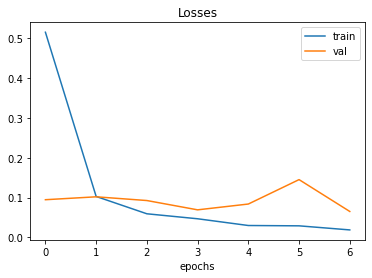

In [10]:
for v,c in sorted(loss_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('Losses')
plt.legend()
plt.show()
#plt.plot(loss

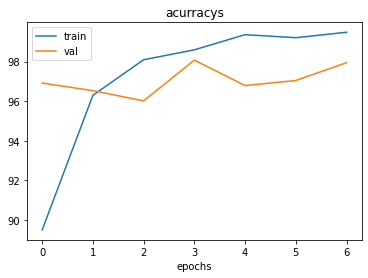

In [11]:
for v,c in sorted(accuracy_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('acurracys')
plt.legend()
plt.show()

In [12]:
torch.save(model.state_dict(), 'model_weights_vgg16_Multiclass_transferlearning.pth')

In [15]:
#preparing test data 
data_dir = "D:\DatasetsCD\Test_set_Multiclasse"


transforms2 = transforms.Compose([transforms.Resize((224,224)),
                                  
                                  transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])
                                                           ])

dataset2 =datasets.ImageFolder(data_dir, transform= transforms2)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1 ,shuffle=True) 

In [16]:
print(len(test_loader))
dataset2.class_to_idx

854


{'COVID': 0, 'NORMAL': 1, 'Pneumonia': 2}

In [33]:
y_true =[]
y_predicted = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        y_test_pred = model(batch_x)
        
        y_pred_soft = torch.log_softmax(y_test_pred,dim = 1)
        _, y_pred = torch.max(y_pred_soft,dim = 1)
       
        y_predicted.append(y_pred.cpu().numpy())
        y_true.append(batch_y.cpu().numpy())

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_predicted, y_true, target_names=['Covid 0', 'NORMAL 1', 'Pneumonia 2']))

              precision    recall  f1-score   support

     Covid 0       0.99      0.99      0.99       366
    NORMAL 1       0.96      0.90      0.93       256
 Pneumonia 2       0.90      0.96      0.93       232

    accuracy                           0.95       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854



In [37]:
conf = confusion_matrix(y_predicted,y_true)
conf

array([[362,   0,   4],
       [  4, 230,  22],
       [  0,  10, 222]], dtype=int64)

In [49]:
idx2class = {v: k for k, v in dataset2.class_to_idx.items()}

idx2class

{0: 'COVID', 1: 'NORMAL', 2: 'Pneumonia'}

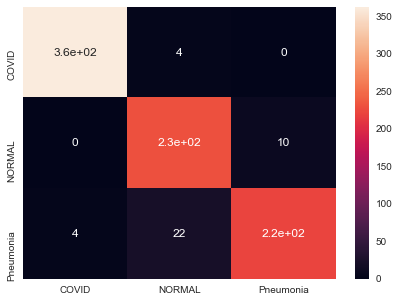

In [48]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_predicted)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)